# Goal: Create customer profiles using clustering methods and customer purchase history

In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN 

import wrangle_profiles as wp

##  Wrangle

The original data contained transaction information for LGS customers from 2001-2004. Items purchased in ‘purchase’ transactions were sorted into one of nine categories. <br>
<br>
Central categories representing major gaming interests include:
* Board Games 
* Role Playing Games
* Trading Card Games
* Tabletop Minis Games
* Modeling Supplies
<a/>

Support Categories represent categories that support or are adjacent to major interests include:
* Accessories
* Concessions
* Game Room Rentals
<a/>

Items that could not be classified were categorized as 
* Other
<a/>

In [2]:
df = wp.get_prepared_profiles_data()

## Explore 

### What does an average customer's spending habits look like?

In [3]:
cats = ['accessories', 
        'board_games', 
        'concessions', 
        'modeling_supplies',
        'role_playing_games', 
        'minis_models', 
        'trading_card_games', 
        'game_room_rental',
        'net_sales']


df[cats].describe()[1:3]

,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games,game_room_rental,net_sales
mean,1.715006,0.474149,4.362547,1.569987,0.165826,0.541614,2.228247,0.059899,172.634332
std,4.503849,1.391602,18.823379,8.263589,0.877833,2.303441,7.990032,0.564630,442.719224


Given the mean and relatively large standard deviation across all categories, penning down the habbits of an 'average' would be unhelpful due to the large variance. Moving forward it will be my goal to identify population clusters were the variance is less severe.

### How many customers does each category appeal to? 

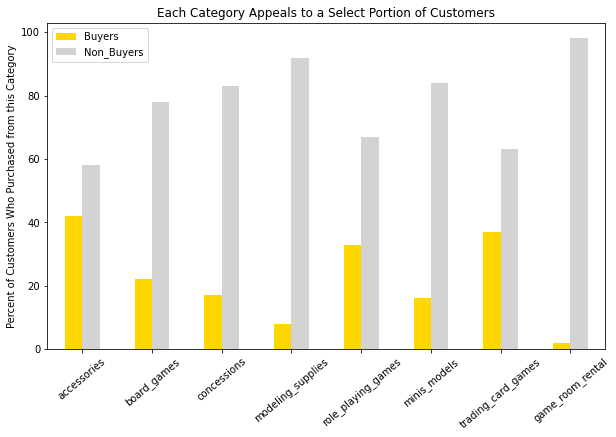

In [4]:
cats = ['accessories', 
        'board_games', 
        'concessions', 
        'modeling_supplies',
        'role_playing_games', 
        'minis_models', 
        'trading_card_games',
        'game_room_rental']

buyers = [round(len(df[df['accessories'] > 0]) / len(df)*100),
          round(len(df[df['board_games'] > 0]) / len(df)*100),
          round(len(df[df['modeling_supplies'] > 0]) / len(df)*100),
          round(len(df[df['role_playing_games'] > 0]) / len(df)*100),
          round(len(df[df['concessions'] > 0]) / len(df)*100),
          round(len(df[df['minis_models'] > 0]) / len(df)*100),
          round(len(df[df['trading_card_games'] > 0]) / len(df)*100),
          round(len(df[df['game_room_rental'] > 0]) / len(df)*100)]
    
non_buyers = [round(len(df[df['accessories'] == 0]) / len(df)*100),
              round(len(df[df['board_games'] == 0]) / len(df)*100),
              round(len(df[df['modeling_supplies'] == 0]) / len(df)*100),
              round(len(df[df['role_playing_games'] == 0]) / len(df)*100),
              round(len(df[df['concessions'] == 0]) / len(df)*100),
              round(len(df[df['minis_models'] == 0]) / len(df)*100),
              round(len(df[df['trading_card_games'] == 0]) / len(df)*100),
              round(len(df[df['game_room_rental'] == 0]) / len(df)*100)]

data = { 'Category':cats,
         'Buyers':buyers,
         'Non_Buyers':non_buyers}

df_data = pd.DataFrame(data)

df_data.set_index('Category', inplace=True)

df_data.plot(kind='bar', figsize=(10, 6), color = ['gold', 'lightgrey'])

plt.xticks(rotation=40)

plt.xlabel('')
plt.ylabel('Percent of Customers Who Purchased from this Category')
plt.title('Each Category Appeals to a Select Portion of Customers')


plt.show()

Each category only appeals to a select amount of customers:
    
Major Categories
* Trading Card Games 37%
* Role Playing Games 33%
* Board Games 22%
* Minis Models 16%
* Modeling Supplies 8%

Support Categories
* Accessories 42%
* Concessions 17%
* Game Room Rental 2%

Major categories appeal to roughly 1/3 of customers or less, likely due to specialized interests of customers <br>
Accesories is the highest apeal category likely do to supporting multiple interests tied to major categories

### Is there a relationship between customers who buy products in one category and customers who buy products in a differint category?

Based on a chi-square test usong an alpha of .05, and the odds ratio of buyers to non-buyers in each category the following relationships exist between these categories:

Customers who bought Board Games
* 78% More likely to buy role playing games
* 61% Less likely to buy trading card games 

Customers who bought Role Playing Games
* 4.23 Times as likely to buy minis models
* 2.59 Times as likely to buy accessories
* 2.21 Times as likely to buy modeling supplies
* 78% More likely to buy board games
* 80% More likely to buy concessions
* 40% decreased odds of buying trading card games

Customers who bought Minis Models
* 8.45 Times as likely to buy modeling supplies
* 4.23 Times as likely to buy Role Playing Games
* 75% More likely to to buy concessions
* 50% Less likely to buy trading card games

Customers who bought Trading Card Games
* 88% More likely to buy accessories
* 47% More likely to buy concessions
* 61% Less likely to buy board games
* 61% Less likely to buy modeling supplies
* 50% Less likely to buy minis models 
* 40% Less likely to buy role playing games

Customers who bought Modeling Supplies
* 8.45 Times as likely to buy minis models
* 2.21 Times as likely to buy role playing games
* 88% increased odds of buying accessories
* 65% More likely to buy concessions
* 61% less likely to buy Trading Card Games 

#### Summary of Major Categories

Board Gamers
* Diversified Interests, not many strong relationships to other categories
* More likely to buy role playing games
* Less likely buy trading card games

Trading Card Gamers
* On their own island, less likely to engage in other major categories
* More likely to buy accessories and concessions

Role Playing Gamers
* Likely a major driver of sales in other categories
* Nearly 3 times as likely to buy accessories
* Over 4 times as likely to buy minis models 
* 2 times as likely to buy modeling supplies
* More likely to buy board games and concessions
* Less likely to buy trading card games

Minis Models
* Comprised of “war gaming” models and models that support role playing games
* Likely a driver of modeling supplies and partially driven by role playing games
* Over 8 times as likely to buy modeling supplies
* More likely to buy concessions
* Less likely to buy trading card games

Modeling supplies
* Likely driven by minis models
* Over 8 times as likely to buy minis models


 #### Category Relationship Tests

In [12]:
# get list of categories to examine
cats = ['accessories', 
        'board_games', 
        'concessions',
        'modeling_supplies', 
        'role_playing_games', 
        'minis_models',
        'trading_card_games']

bought_cats = []

# get true/false column for each category for count > 0
for cat in cats:
    
    bought_cat = f'bought_{cat}'
    
    df[bought_cat] = df[cat] > 0
    
    bought_cats.append(bought_cat)
    
# get category combinations
combs = combinations(bought_cats, 2)

# Get print out fro each singificant relationship
for comb in combs:
    
    # get categories and make contengency table
    alpha = .05
    cat1 = df[comb[0]]
    cat2 = df[comb[1]]

    ct = pd.crosstab(cat2, cat1)
    
    chi2, p, dof, expected = chi2_contingency(ct)
    
    # if significant relation ship print p value and odds ration
    if p < alpha:

        # get values from crosstab
        true_true = ct.loc[1, 1]
        true_false = ct.loc[1, 0]
        false_false = ct.loc[0, 0]
        false_true = ct.loc[0, 1]

        # calculate odds ratio
        true_ratio = true_true/true_false
        false_ratio = false_true/false_false

        odds_ratio = round(true_ratio/false_ratio,2)
    
    
        # print results     
        print(comb[0], 'and', comb[1])
        print('--------------------------------------------------------')
        print('Chi-Square P-Value:', p)
        print('Odds Ratio:', odds_ratio)
        print()

bought_accessories and bought_concessions
--------------------------------------------------------
Chi-Square P-Value: 0.00022898142106283562
Odds Ratio: 1.49

bought_accessories and bought_role_playing_games
--------------------------------------------------------
Chi-Square P-Value: 2.637590995781412e-07
Odds Ratio: 2.59

bought_accessories and bought_trading_card_games
--------------------------------------------------------
Chi-Square P-Value: 2.6189298764791124e-09
Odds Ratio: 1.88

bought_board_games and bought_role_playing_games
--------------------------------------------------------
Chi-Square P-Value: 0.003992273243111018
Odds Ratio: 1.78

bought_board_games and bought_trading_card_games
--------------------------------------------------------
Chi-Square P-Value: 3.903131004282979e-11
Odds Ratio: 0.39

bought_concessions and bought_modeling_supplies
--------------------------------------------------------
Chi-Square P-Value: 0.0002876863942808126
Odds Ratio: 1.65

bought_conc

### Is there a relationship between major groups and customer spending?

In [15]:
df_bg = df[df.bought_board_games == True] 
df_rpg = df[df.bought_role_playing_games == True]
df_tcg = df[df.bought_trading_card_games == True]
df_min = df[df.bought_minis_models == True]
df_sup = df[df.bought_modeling_supplies == True]

In [26]:
cats = ['accessories', 
        'board_games', 
        'concessions', 
        'modeling_supplies',
        'role_playing_games', 
        'minis_models', 
        'trading_card_games', 
        'game_room_rental',
        'net_sales']

In [28]:
df[cats].describe()[:3]

,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games,game_room_rental,net_sales
count,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000
mean,1.715006,0.474149,4.362547,1.569987,0.165826,0.541614,2.228247,0.059899,172.634332
std,4.503849,1.391602,18.823379,8.263589,0.877833,2.303441,7.990032,0.564630,442.719224


In [45]:
df[df.board_games >20][cats]

,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games,game_room_rental,net_sales
1556,18,21,136,68,24,37,0,2,3455.97


In [47]:
df[df.net_sales  > 3000][cats]

,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games,game_room_rental,net_sales
100,26,6,106,204,3,0,22,0,3759.00
409,18,6,60,20,5,16,55,0,6018.53
451,28,6,304,0,0,4,60,0,6549.01
1089,12,0,5,0,0,0,27,0,5458.49
1346,25,5,261,15,1,10,120,0,5829.75
1462,38,7,34,20,0,7,107,0,5891.28
1556,18,21,136,68,24,37,0,2,3455.97


<AxesSubplot:>

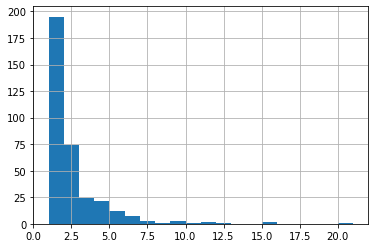

In [43]:
df_bg.board_games.hist(bins = 20)

In [37]:
df.net_sales.mean()

172.63433165195448

In [42]:
df.net_sales.sum()

273798.05000000005

In [38]:
df_rpg.net_sales.mean()

465.54253731343266

In [39]:
df_tcg.net_sales.mean()

304.6422564102567

In [40]:
df_min.net_sales.mean()

427.0697244094494

In [41]:
df_sup[cats].net_sales.mean()

346.9132481751826

<AxesSubplot:>

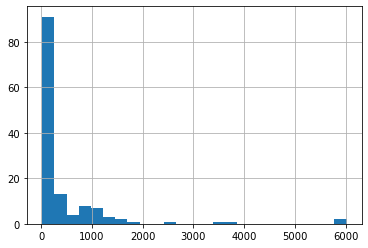

In [19]:
df_rpg.net_sales.net_sales.mean()

<AxesSubplot:>

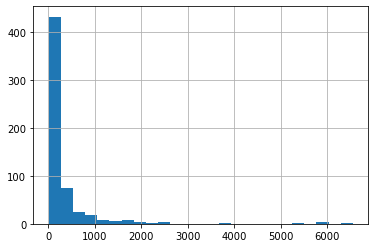

In [20]:
df_tcg.net_sales.hist(bins = 25)

<AxesSubplot:>

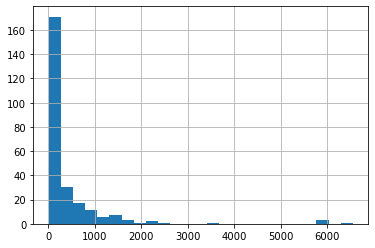

In [21]:
df_min.net_sales.hist(bins = 25)

<AxesSubplot:>

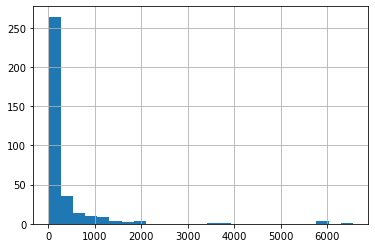

In [34]:
df_bg.net_sales.hist(bins = 25)

In [ ]:
df_bg = df[['accessories', 
                  'board_games', 
                  'concessions', 
                  'modeling_supplies',
                  'role_playing_games', 
                  'minis_models', 
                  'trading_card_games', 
                  'other',
                  'game_room_rental', 
                  'all_items',
                  'net_sales',
                  'tenure']][df.board_games > 0]



df_bg.describe()

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

df_bg['cluster'] = kmeans.predict(X)

df_bg.sample(10)

In [ ]:
df_bg.cluster.value_counts()

In [ ]:
# Board Game Clusters

In [ ]:
df_bg[df_bg.cluster == 0].describe()[1:3]

In [ ]:
df_bg[df_bg.cluster == 2].describe()[1:3]

In [ ]:
df_bg[df_bg.cluster == 1].describe()[1:3]

# TCG Clusters

In [ ]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)

df_tcg['cluster'] = kmeans.predict(X)

df_tcg.sample(10)

In [ ]:
df_tcg.cluster.value_counts()

In [ ]:
df_tcg.describe()[1:3]

In [ ]:
df_tcg[df_tcg.cluster == 0].describe()[1:3]

In [ ]:
df_tcg[df_tcg.cluster == 2].describe()[1:3]

In [ ]:
df_tcg[df_tcg.cluster == 1].describe()[1:3]

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

df_bg['cluster'] = kmeans.predict(X)

df_tcg.sample(10)

In [ ]:
X = df_tcg[['net_sales']]

with plt.style.context('seaborn-whitegrid'):
    
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [ ]:


cols = ['net_sales']

X = df_bg[cols]

model = DBSCAN().fit(X)

df_bg['cluster'] = model.labels_

df_bg.cluster.value_counts()

In [ ]:
df_bg

In [ ]:
df_bg[df_bg.cluster == 0]

In [ ]:
df_bg[df_bg.cluster == 1]

In [ ]:
df_bg[df_bg.cluster == 2]

In [ ]:
df_bg[df_bg.cluster == 3]

In [ ]:
df_cats = df[['accessories', 
                  'board_games', 
                  'concessions', 
                  'modeling_supplies',
                  'role_playing_games', 
                  'minis_models', 
                  'trading_card_games', 
                  'other',
                  'game_room_rental', 
                  'all_items',
                  'net_sales']]

In [ ]:
df_cats

In [ ]:
cols = ['accessories', 
        'board_games', 
        'concessions', 
        'modeling_supplies',
        'role_playing_games', 
        'minis_models', 
        'trading_card_games', 
        'other',
        'game_room_rental', 
        'all_items',
        'net_sales']

for col in cols:
    
    df[cols].hist(col, bins = 50)
    plt.show()
    
    

In [ ]:
df.hist('accessories', bins = 50)

In [ ]:
df[raw_num].describe()

In [ ]:
for col in raw_num:
    
    print()
    print(col.upper())
    print()
    print (f'{round(len(df[df[col] > 0]) / len(df)*100)}% buyers')
    print (f'{round(len(df[df[col] == 0]) / len(df)*100)}% NON-buyers')
    

In [ ]:
df[raw_num]

In [ ]:
df[raw_num][df.trading_card_games > 0].describe()

In [ ]:
df[raw_num][df.accessories > 0].describe()

In [ ]:
df[raw_num][df.concessions > 0].describe()

In [ ]:
df[raw_num][df.modeling_supplies > 0].describe()

In [ ]:
sns.heatmap(df)

In [ ]:
cols = ['accessories', 
        'board_games', 
        'concessions',
        'modeling_supplies', 
        'role_playing_games', 
        'minis_models',
        'trading_card_games',
        'game_room']

for col in cols:
    
    
    print(col, 'Hist')
    
    plt.hist(df[raw_num][df[col] > 0])
    
    plt.show()